In [1]:
import pandas as pd
import lightkurve as lk
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.timeseries import LombScargle
from astropy.table import Table
from scipy.signal import savgol_filter as savgol
from pathlib import Path
from scipy import ndimage

from astropy.table import Table 
from astropy.io import fits

import astropy.units as u
from astropy.visualization import quantity_support, time_support
time_support()
quantity_support()

import copy
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
import halophot
print('halophot: {}'.format(halophot.__version__))

halophot: 0.7.6


In [3]:
def remove_outliers(data, max_deviations = 2):
    median = np.nanmedian(data)
    standard_dev = np.std(data)
    data_dist = abs(data - median)
    result = np.where(data_dist < max_deviations * standard_dev, data, median)
    return result

def get_best_freq(time, flux, min_period=4./24., max_period=30.):
    frequency, power = LombScargle(time, flux).autopower(minimum_frequency=1./max_period,
                                                                                         maximum_frequency=1./min_period, 
                                                                                         samples_per_peak=3)
    best_freq = frequency[np.argmax(power)]

    # refine
    for j in range(3):
        ls = LombScargle(time, flux)
        frequency, power = ls.autopower(minimum_frequency=best_freq*(1-1e-3*(3-j)),maximum_frequency=best_freq*(1+1e-3*(3-j)), 
                                                                                         samples_per_peak=500)
        best_freq = frequency[np.argmax(power)]

    falarm = ls.false_alarm_probability(np.max(power))

    return best_freq, ls.power(best_freq,normalization='psd'), falarm

def iterative_sine_fit(time, flux, nmax, min_period=4./24., max_period=30.):
    ff, pp = [], []
    y_fit = 0
    flux2 = copy.copy(flux)

    for j in range(nmax):
        best_freq, maxpower, falarm = get_best_freq(time, flux2)
        
        ff.append(best_freq)
        pp.append(maxpower)
        y_fit += LombScargle(time, flux2-1).model(time, best_freq)
        flux2 = flux - y_fit

    flux_fit = y_fit + np.nanmedian(ydata_right)
        
    return flux_fit, flux2, np.array(ff), np.array(pp)

def normalize(xx):
    # this makes your time stamps go from 0 to 1, for convenients
    return (xx-xx.min())/(xx.max()-xx.min())

## Upload data:

In [4]:
name = "98 Tau"
epic_id = "200173870"

#download tess

corr_lc = Table.read('98_tau_corrected_tess_lc.fits')

tess_time = corr_lc['TIME'].data
tess_flux = corr_lc['FLUX']/np.nanmedian(corr_lc['FLUX'])
tess_flux_no_outliers = remove_outliers(tess_flux, 1)

tess_trend_func = poly.Polynomial.fit(tess_time, tess_flux_no_outliers, 3)
tess_trend = tess_trend_func(tess_time)
tess_flux_no_trend = tess_flux - tess_trend + np.nanmedian(tess_trend)

freqs_tess = np.linspace((1/10.),360.,10000) # tess from 10 day period to 360 c/d nyquist
ls_tess = LombScargle(tess_time, tess_flux, normalization='standard')
power_tess = ls_tess.power(freqs_tess)
max_freq_tess = np.round(freqs_tess[power_tess.argmax()], 3)
tess_smothed_periodogram = ndimage.gaussian_filter1d(power_tess,6)



#download halo

corr_lc = Table.read('98_Tau_halo_k2sc.fits')
halo = corr_lc

m = np.isfinite(halo['flux'])
halo = halo[m]
halo_flux = halo['flux']
halo_time = halo['time'].data
halo_corr_flux = halo['flux']

halo_corr_median = np.nanmedian(halo_corr_flux)
halo_normalized_flux = halo_corr_flux/halo_corr_median
halo_corr_no_outliers = remove_outliers(halo_corr_flux)
halo_trend = savgol(halo_corr_no_outliers/halo_corr_median,701,3)

halo_lc = LombScargle(halo_time,halo_corr_flux/halo_corr_median-halo_trend+np.nanmedian(halo_trend),normalization='standard') #+np.nanmedian(halo_trend)
freqs_halo = np.linspace((1/30.),24.,10000) 
power_halo = halo_lc.power(freqs_halo)
max_freq_halo = np.round(freqs_halo[power_halo.argmax()], 3)

halo_smothed_periodogram = ndimage.gaussian_filter1d(power_halo,10)


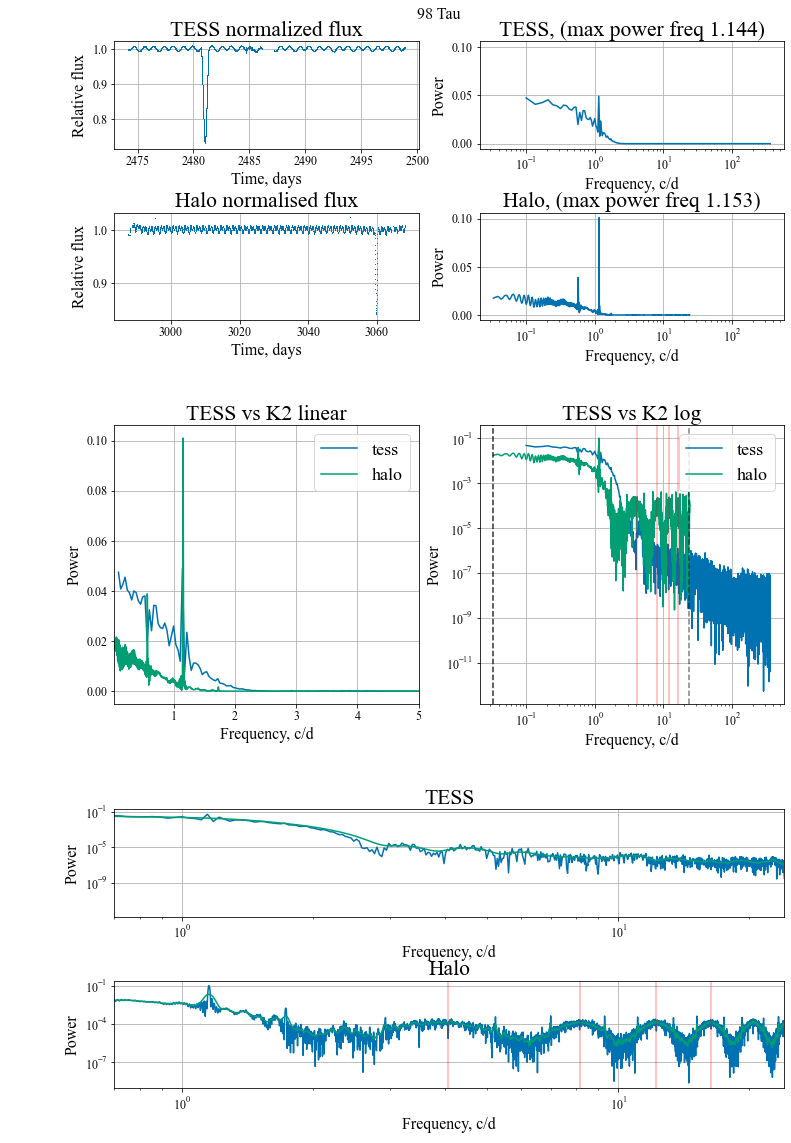

In [5]:
#MAKE PLOTS 

fig = plt.figure(figsize=(12.0,16))
fig.subplots_adjust(top=0.85)

fig.suptitle(name, fontsize=16)

figs = fig.subfigures(nrows=3, ncols=1)

fig1 = figs[0]
fig1.subplots_adjust(hspace=0.6)
ax1 = fig1.add_subplot(221)
#plt.plot(tess_time, tess_flux, ',')
plt.plot(tess_time, tess_flux_no_trend, ',')
#plt.plot(tess_time, tess_flux_no_outliers, ',')
#plt.plot(tess_time, tess_trend, ',')
plt.yscale('linear')
plt.ylabel('Relative flux')
plt.xlabel('Time, days')
plt.title('TESS normalized flux')
plt.grid(True)
ax2 = fig1.add_subplot(222)
plt.plot(freqs_tess, power_tess)
plt.xscale('log')
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.title('TESS, (max power freq %s)' %max_freq_tess)
plt.grid(True)
ax3 = fig1.add_subplot(223)
plt.plot(halo_time, halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend), ',')
plt.yscale('linear')
plt.ylabel('Relative flux')
plt.xlabel('Time, days')
plt.title('Halo normalised flux')
plt.grid(True)
ax4 = fig1.add_subplot(224, sharex=ax2, sharey=ax2)
plt.plot(freqs_halo, power_halo)
plt.xscale('log')
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.title('Halo, (max power freq %s)' %max_freq_halo)
plt.grid(True)
fig2 = figs[1]
ax8 = fig2.add_subplot(121)
plt.plot(freqs_tess, power_tess, label="tess")
plt.plot(freqs_halo, power_halo, label="halo")
plt.xlim(1/30., 5.)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right", )
plt.title('TESS vs K2 linear')
plt.grid(True)
ax9 = fig2.add_subplot(122)
plt.plot(freqs_tess, power_tess, label="tess")
plt.plot(freqs_halo, power_halo, label="halo")
plt.legend(loc="upper right", )
plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
plt.axvline(24., alpha=0.5,linestyle='--',color='k') 
#thruster fire harmonics
plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.title('TESS vs K2 log')
plt.grid(True)


fig3 = figs[2]
#fig3.suptitle('Smoothed', fontsize=16)
ax5 = fig3.add_subplot(211)
plt.plot(freqs_tess, power_tess, freqs_tess, tess_smothed_periodogram)
plt.xlim(0.7, 24.)
plt.xscale('log')
plt.yscale('log')
plt.title('TESS')
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.grid(True)
ax6 = fig3.add_subplot(212)
plt.plot(freqs_halo, power_halo, freqs_halo, halo_smothed_periodogram)
plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
plt.xlim(0.7, 24.)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo')
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.grid(True)

#pp = PdfPages('reports/%s_%s.pdf' % (epic_id, name))
#pp.savefig(fig)
#pp.close()

In [6]:
#type(corr_lc['TIME'])

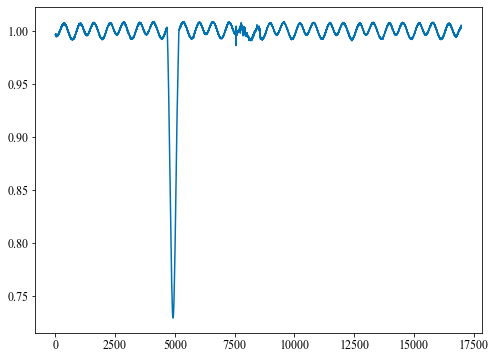

In [7]:
plt.plot(tess_flux_no_trend/np.nanmedian(tess_flux_no_trend))

(0.99, 1.01)

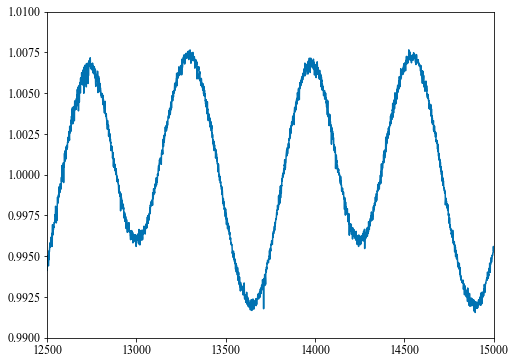

In [8]:
plt.plot(tess_flux)
#plt.plot(tess_trend_reg_cor)
#plt.plot(tess_flux_reg_cor_no_outliers)
#plt.plot(tess_flux_no_trend_reg_cor)
plt.xlim(12500, 15000)
plt.ylim(0.99, 1.01)

## Check eclipse:

(-5.0, 5.0)

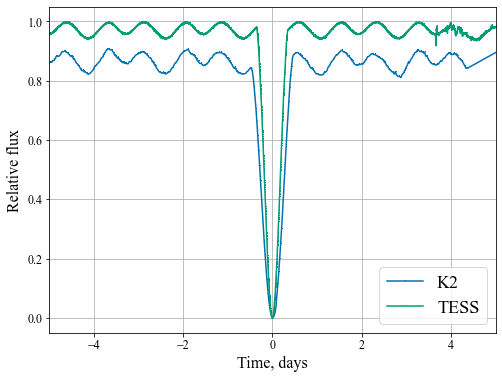

In [9]:
halo_to_plot = halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend)

halo_time_val = halo_time
halo_time_norm = (halo_time_val - np.mean(halo_time_val))
plt.plot((halo_time_norm - halo_time_norm[np.argmin(halo_to_plot)]), (halo_to_plot - min(halo_to_plot))/(max(halo_to_plot) - min(halo_to_plot)), ',-' , label="K2")
plt.yscale('linear')
plt.ylabel('Relative flux')

tess_time_norm = (tess_time - np.mean(tess_time))
plt.plot((tess_time_norm - tess_time_norm[np.argmin(tess_flux)]), (tess_flux - min(tess_flux))/(max(tess_flux) - min(tess_flux)), ',-', label="TESS")
plt.yscale('linear')
plt.ylabel('Relative flux')
plt.xlabel('Time, days')
plt.grid(True)
plt.legend(loc='lower right')

plt.xlim(-5, 5)

(-2.0, 2.0)

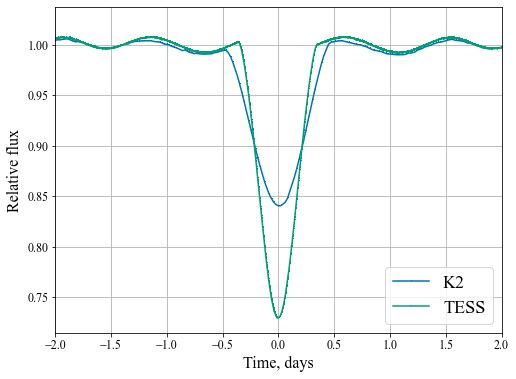

In [10]:
halo_to_plot = halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend)

halo_time_val = halo_time
halo_time_norm = (halo_time_val - np.mean(halo_time_val))
plt.plot((halo_time_norm - halo_time_norm[np.argmin(halo_to_plot)]), halo_to_plot, ',-' , label="K2")
plt.yscale('linear')
plt.ylabel('Relative flux')

tess_time_norm = (tess_time - np.mean(tess_time))
plt.plot((tess_time_norm - tess_time_norm[np.argmin(tess_flux)]), tess_flux, ',-', label="TESS")
plt.yscale('linear')
plt.ylabel('Relative flux')
plt.xlabel('Time, days')
plt.grid(True)
plt.legend(loc='lower right')

plt.xlim(-2, 2)

(0.98, 1.01)

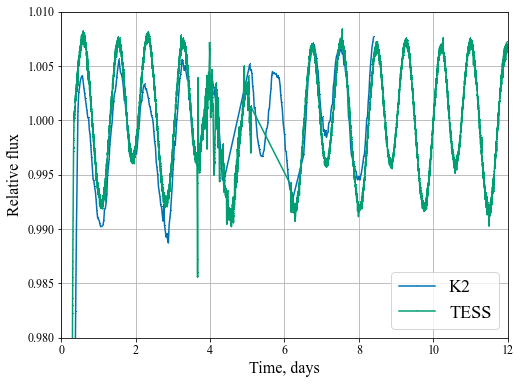

In [11]:
halo_to_plot = halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend)

#halo_time_norm = (halo_time - np.mean(halo_time))
#plt.plot((halo_time_norm - halo_time_norm[np.argmin(halo_to_plot)]), (halo_to_plot - min(halo_to_plot))/(max(halo_to_plot) - min(halo_to_plot)), ',-' , label="K2")
plt.plot((halo_time_norm - halo_time_norm[np.argmin(halo_to_plot)]), halo_to_plot, ',-' , label="K2")
plt.yscale('linear')
plt.ylabel('Relative flux')

#tess_time_norm = (tess_time_reg_cor - np.mean(tess_time_reg_cor))
#plt.plot((tess_time_norm - tess_time_norm[np.argmin(tess_flux_reg_cor)]), (tess_flux_reg_cor - min(tess_flux_reg_cor))/(max(tess_flux_reg_cor) - min(tess_flux_reg_cor)), ',-', label="TESS")
plt.plot((tess_time_norm - tess_time_norm[np.argmin(tess_flux)]), tess_flux, ',-', label="TESS")
plt.yscale('linear')
plt.ylabel('Relative flux')
plt.xlabel('Time, days')
plt.grid(True)
plt.legend(loc='lower right')

plt.xlim(0, 12)
plt.ylim(0.98, 1.01)

In [12]:
def process_fits(x_data, y_data, label):
    
    print('Points: ', y_data.shape)
    
    # Plot original data
    #fig = plt.figure(figsize=(12.0,9.0))
    #fig.suptitle(label)
    #plt.plot(x_data, y_data, 'b-', label='data')
    
    # Do fits
    
    #y_fit, delta, ff, pp = iterative_sine_fit(x_data, y_data, 2)

    #fig = plt.figure(figsize=(12.0,9.0))
    #fig.suptitle(label + ' Fit')
    #plt.plot(x_data, y_data, label= "data")
    #plt.plot(x_data, y_fit, label = "fit")
    #plt.legend(loc="upper right")
    #print(ff)
    #print(pp)
    
    
    # Fit with Lombscargle
    freqs = np.linspace((1/10.),36.,10000) # tess from 100 day period to 360 c/d nyquist
    ls_fit = LombScargle(x_data, y_data, normalization='psd')
    power_data = ls_fit.power(freqs)
    
    ls_fit.nterms = 4
    
    period = 1/freqs[np.argmax(power_data)]
    print('Main period: ', period)
    
    y_fit_ls = ls_fit.model(x_data, 1/(2*period))

    phase = (x_data) % (period*2)
    args = np.argsort(phase)
    
    #fig = plt.figure(figsize=(12.0,9.0))
    #plt.plot(phase, y_data,'.',alpha=0.2, label="Detrended data" )
    #plt.plot(phase[args], y_fit_ls[args],'-', label="Sin fit")
    #plt.legend(loc="upper right")
    
    
    # Find coefficients
    design_matrix = ls_fit.design_matrix(1/period) # use the true period here

    fig = plt.figure(figsize=(12.0,9.0))
    fig.suptitle(label + ' Design Matrix')
    for j in range(5):
        plt.plot(design_matrix[:,j]+j*2)
    
    basis_v = np.vander(normalize(x_data),3)[:,:-1] # vander (short for vandermonde) is a matrix of 1, x, x**2 
    # we want to throw away the constant term, which is listed last, because LS has one already
    basis = np.hstack([design_matrix, basis_v]) # this makes a combined basis of constant, sines, x, and x**2

    soln_1 = np.linalg.lstsq(basis, y_data) # this does the inverse square solution

    coeffs_1 = soln_1[0] # lstsq returns the solution, and metadata about the solver
    
    plt.plot([0,1,2], [1, np.sqrt(coeffs_1[1]**2 + coeffs_1[2]**2), np.sqrt(coeffs_1[3]**2 + coeffs_1[4]**2)])

    constant_part = coeffs_1[0]
    fundamental_part = np.sqrt(coeffs_1[1]**2 + coeffs_1[2]**2)
    harmonic_part = np.sqrt(coeffs_1[3]**2 + coeffs_1[4]**2)
    print('Constant:', constant_part)
    print('Fundamental: %.2g' % fundamental_part)
    #print('Fundamental 0: %.2g' % coeffs_1[1])
    #print('Fundamental 1: %.2g' % coeffs_1[2])
    print('Harmonic: %.9g' % harmonic_part)
    #print('Harmonic 0: %.9g' % coeffs_1[3])
    #print('Harmonic 1: %.9g' % coeffs_1[4])
    
    print('Linear: %.9g' % coeffs_1[5])
    print('Quadratic: %.9g' % coeffs_1[6])
    
    return (basis, soln_1, coeffs_1)


## 1. Noise after eclipse (TESS):

Points:  (7990,)
Main period:  0.8680742451339571
Constant: 1.0008983929014554
Fundamental: 0.0063
Harmonic: 5.97199088e-05
Linear: 1.96387988e-06
Quadratic: -1.67132872e-05


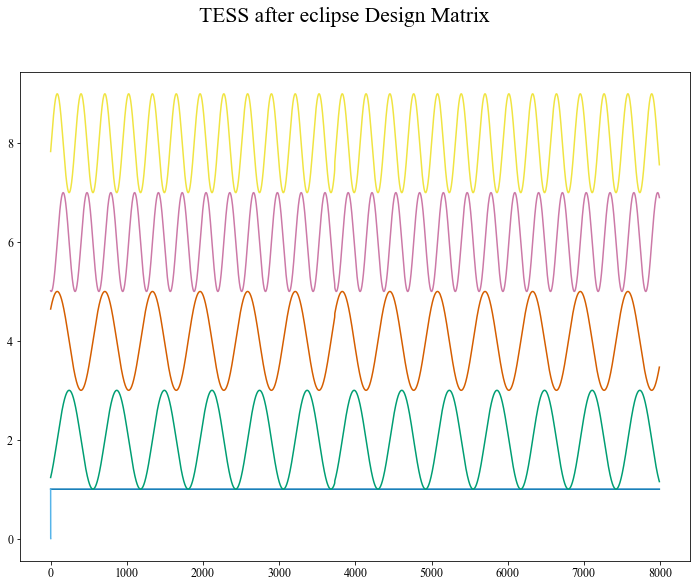

In [13]:
ydata_right = tess_flux[9000:].data
xdata_right = tess_time[9000:]

(basis_right, soln_right, coeffs_right) = process_fits(xdata_right, ydata_right, "TESS after eclipse")

## 2. Noise before eclipse (TESS):

Points:  (4500,)
Main period:  0.8680742451339571
Constant: 1.0012002749260527
Fundamental: 0.0063
Harmonic: 6.21409456e-05
Linear: -8.76053499e-06
Quadratic: -3.72541617e-05


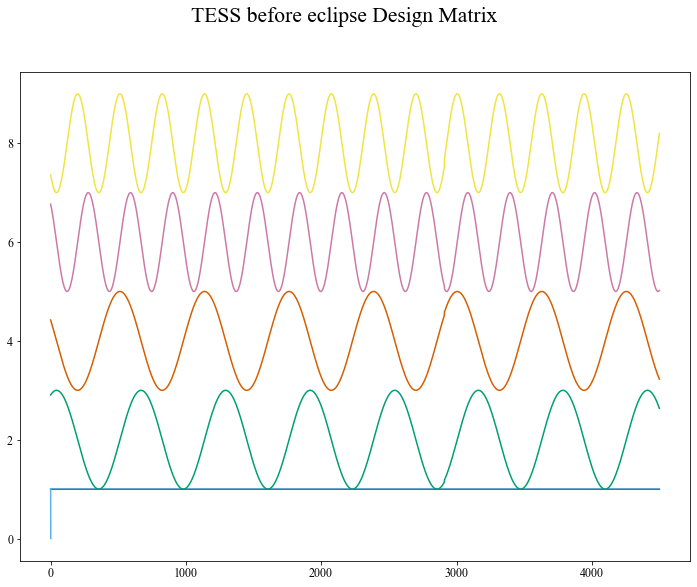

In [14]:
ydata_left = tess_flux[:4500].data
xdata_left = tess_time[:4500]

(basis_left, soln_left, coeffs_left) = process_fits(xdata_left, ydata_left, "TESS before eclipse")

# Let's check before and after eclipse in K2.
## 3. Noise after eclipse:

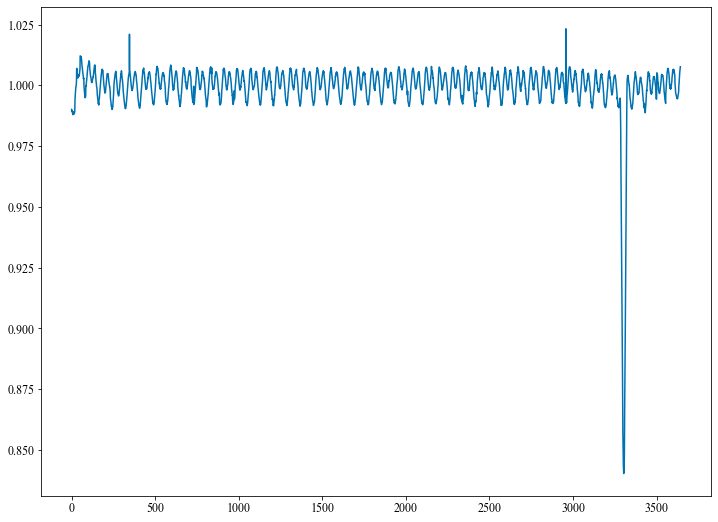

In [15]:
fig = plt.figure(figsize=(12.0,9.0))
plt.plot(halo_to_plot)

Points:  (318,)
Main period:  0.8653771257951446
Constant: 0.9969062709739237
Fundamental: 0.0049
Harmonic: 3.51172524e-05
Linear: -0.000206672176
Quadratic: 0.000272089626


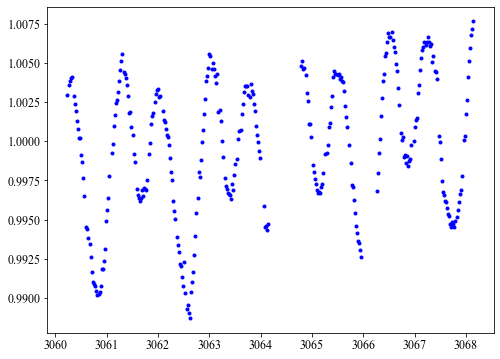

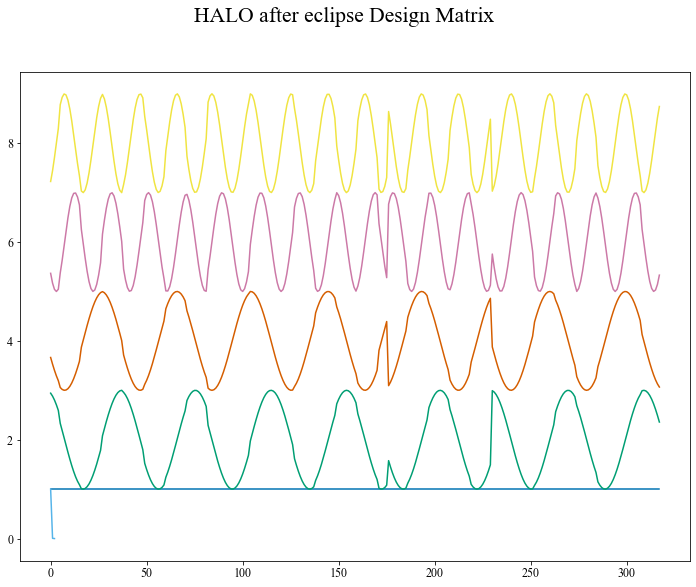

In [16]:
ydata_right_halo = halo_to_plot[3325:]
xdata_right_halo = halo_time[3325:]
plt.plot(xdata_right_halo, ydata_right_halo, 'b.', label='data')

(basis_right_halo, soln_right_halo, coeffs_right_halo) = process_fits(xdata_right_halo, ydata_right_halo, "HALO after eclipse")

In [17]:
freqs_halo = np.linspace((1/10.),36.,10000) # tess from 100 day period to 360 c/d nyquist
ls_halo_right = LombScargle(xdata_right_halo, ydata_right_halo, normalization='psd',nterms=4)
power_halo_right = ls_halo_right.power(freqs_halo)

In [18]:
ls_halo_right.nterms = 4

In [19]:
1/freqs_halo[np.argmax(power_halo_right)]

3.4448425549507333

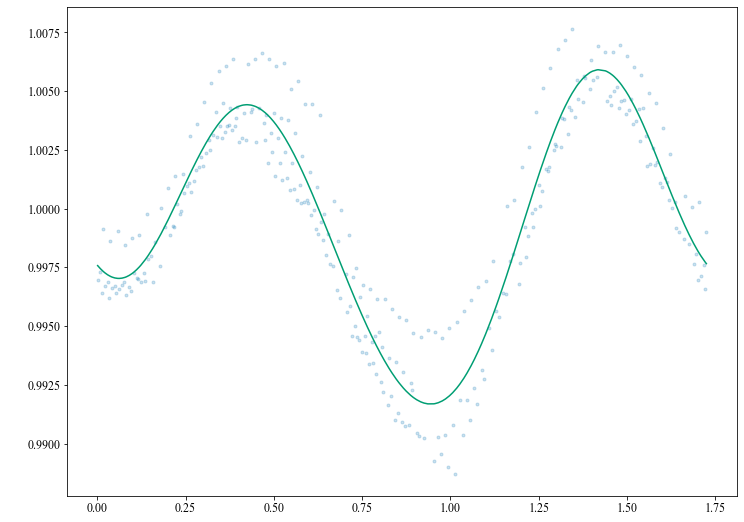

In [20]:
period_halo_right = 0.8643740356730731
y_fit_right_halo = ls_halo_right.model(xdata_right_halo,1/(2*period_halo_right))
# y_fit_right, delta_right, ff_right, pp_right = iterative_sine_fit(xdata_right, ydata_right, 2)
phase = (xdata_right_halo) % (period_halo_right*2)
args = np.argsort(phase)
args2 = np.argsort(args)


fig = plt.figure(figsize=(12.0,9.0))

plt.plot(phase[args], ydata_right_halo[args],'.',alpha=0.2 )
plt.plot(phase[args], y_fit_right_halo[args],'-',alpha=1 )

In [21]:
def normalize(xx):
    # this makes your time stamps go from 0 to 1, for convenients
    return (xx-xx.min())/(xx.max()-xx.min())

dm_halo_right = ls_halo_right.design_matrix(1/(period_halo_right)) # use the true period here

basis_v_halo_right = np.vander(normalize(xdata_right_halo),3)[:,:-1] # vander (short for vandermonde) is a matrix of 1, x, x**2 
# we want to throw away the constant term, which is listed last, because LS has one already
basis_halo_right = np.hstack([dm_halo_right,basis_v_halo_right]) # this makes a combined basis of constant, sines, x, and x**2

soln_3 = np.linalg.lstsq(basis_halo_right,ydata_right_halo) # this does the inverse square solution

coeffs_3 = soln_3[0] # lstsq returns the solution, and metadata about the solver

trend_3 = np.dot(basis_halo_right,coeffs_3)


basis_ls = np.hstack([dm_halo_right[:,[0]], basis_v_halo_right])
coeffs_ls = np.hstack([coeffs_3[[0]], coeffs_3[-2:]])

trend_linsq = np.dot(basis_ls, coeffs_ls)

trend_sq = np.dot(basis_v_halo_right, coeffs_3[-2:])

ydata_right_halo_no_trend = (ydata_right_halo - trend_sq)/np.nanmedian(ydata_right_halo - trend_sq)

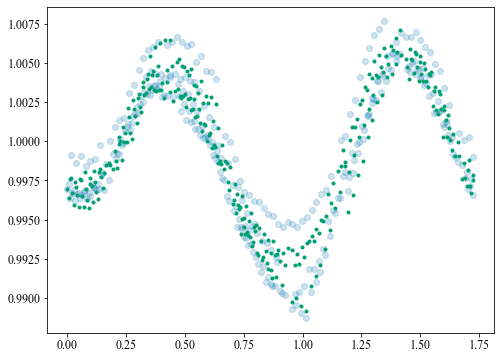

In [22]:

plt.plot((xdata_right_halo) % (period_halo_right*2), ydata_right_halo,'o',alpha=0.2 )
#plt.plot((xdata_left_halo) % (period*2), y_fit_left_halo,'.',alpha=0.2 )

#plt.plot((xdata_left_halo) % (period*2), trend,'*',alpha=0.5 )

#plt.plot((xdata_left_halo) % (period*2), trend_linsq,'o' )

plt.plot((xdata_right_halo) % (period_halo_right*2), ydata_right_halo_no_trend, '.')

In [23]:
ydata_right_halo_no_trend = (ydata_right_halo - trend_sq)/np.nanmedian(ydata_right_halo - trend_sq)

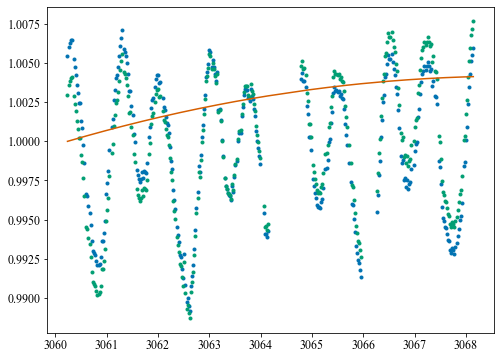

In [24]:
plt.plot(xdata_right_halo,ydata_right_halo_no_trend,'.')
plt.plot(xdata_right_halo,ydata_right_halo,'.')
plt.plot(xdata_right_halo,trend_sq+1)

In [25]:
freqs_halo = np.linspace((1/10.),36.,10000) # tess from 100 day period to 360 c/d nyquist
ls_halo_right_no_trend = LombScargle(xdata_right_halo, ydata_right_halo_no_trend, normalization='psd')
power_halo_right_no_trend = ls_halo_right_no_trend.power(freqs_halo)

In [26]:
ls_halo_right_no_trend.nterms = 4
1/freqs_halo[np.argmax(power_halo_right_no_trend)]

0.8653771257951446

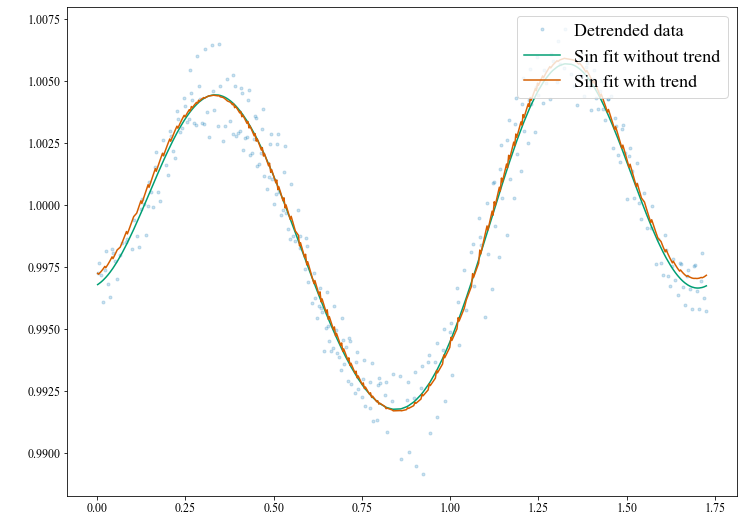

In [27]:
period_halo_right = 0.8653771257951446
y_fit_right_halo_no_trend = ls_halo_right_no_trend.model(xdata_right_halo,1/(2*period_halo_right))
# y_fit_right, delta_right, ff_right, pp_right = iterative_sine_fit(xdata_right, ydata_right, 2)

phase = (xdata_right_halo) % (period_halo_right*2)
args = np.argsort(phase)
fig = plt.figure(figsize=(12.0,9.0))

plt.plot(phase, ydata_right_halo_no_trend,'.',alpha=0.2, label="Detrended data" )
plt.plot(phase[args], y_fit_right_halo_no_trend[args],'-', label="Sin fit without trend" )
plt.plot(phase[args], y_fit_right_halo[args],'-', label="Sin fit with trend" )
plt.legend(loc="upper right")

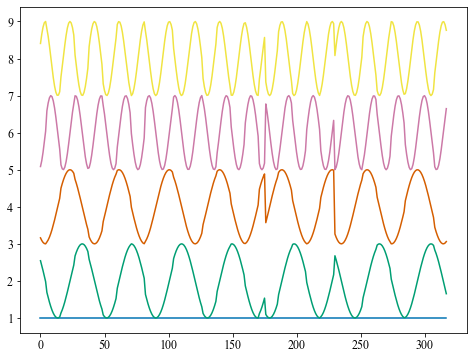

In [28]:
for j in range(5):
    plt.plot(dm_halo_right[:,j]+j*2)

In [29]:
constant_halo_right = coeffs_3[0]
fundamental_halo_right = np.sqrt(coeffs_3[1]**2 + coeffs_3[2]**2)
harmonic_halo_right = np.sqrt(coeffs_3[3]**2 + coeffs_3[4]**2)
print('Constant:',constant_halo_right)
print('Fundamental: %.2g' % fundamental_halo_right)
print('Harmonic: %.9g' % harmonic_halo_right)

Constant: 0.9968847196953293
Fundamental: 0.0049
Harmonic: 3.93669506e-05


In [30]:
residuals_right_halo = ydata_right_halo_no_trend - y_fit_right_halo

In [31]:
freqs_noise_right_halo = np.linspace((1/10.),20.,1000000) # tess from 10 day period to 360 c/d nyquist
ls_noise_right_halo = LombScargle(xdata_right_halo, residuals_right_halo, normalization='psd', fit_mean=False, center_data=True)
power_noise_right_halo = ls_noise_right_halo.power(freqs_noise_right_halo)

Text(0.5, 1.0, 'Right side from eclipse')

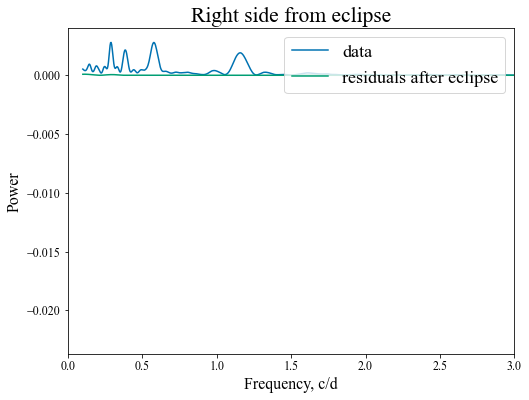

In [32]:
plt.plot(freqs_halo, power_halo_right, label="data")
plt.plot(freqs_noise_right_halo, power_noise_right_halo, label="residuals after eclipse")
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")
plt.title('Right side from eclipse')

Text(0.5, 1.0, 'Right side from eclipse')

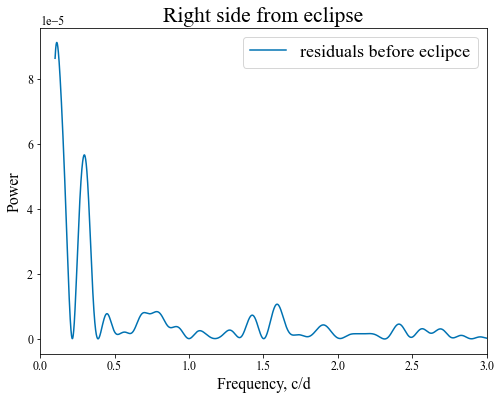

In [33]:
plt.plot(freqs_noise_right_halo, power_noise_right_halo, label="residuals before eclipce")
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")
plt.title('Right side from eclipse')

## 4. Halo noise before eclipse:

Points:  (2500,)
Main period:  0.8680742451339571
Constant: 1.0009316537242798
Fundamental: 0.0049
Harmonic: 0.000128216678
Linear: -5.51684778e-05
Quadratic: 0.000140605652


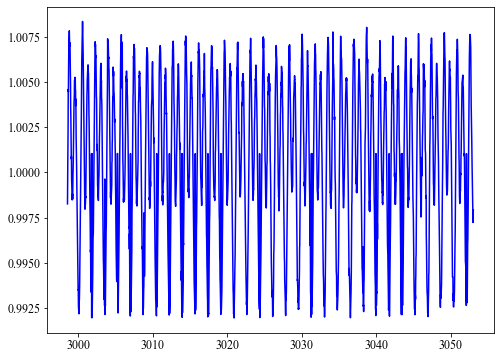

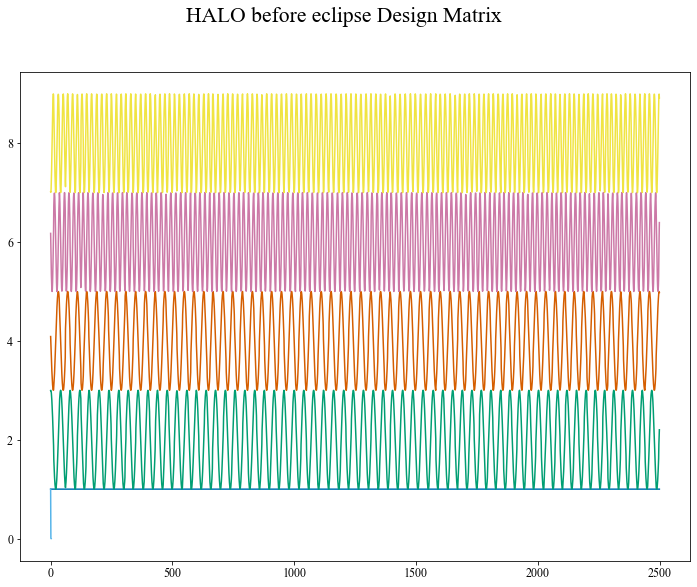

In [34]:
ydata_left_halo = remove_outliers(halo_to_plot[500:3000])
xdata_left_halo = halo_time[500:3000]
plt.plot(xdata_left_halo, ydata_left_halo, 'b-', label='data')


(basis_left_halo, soln_left_halo, coeffs_left_halo) = process_fits(xdata_left_halo, ydata_left_halo, "HALO before eclipse")

In [35]:
freqs_halo = np.linspace((1/10.),36.,100000) # tess from 100 day period to 360 c/d nyquist
ls_halo_left = LombScargle(xdata_left_halo, ydata_left_halo, normalization='psd')
power_halo_left = ls_halo_left.power(freqs_halo)

In [36]:
ls_halo_left.nterms = 4

In [37]:
1/freqs_halo[np.argmax(power_halo_left)]

0.8681455964176481

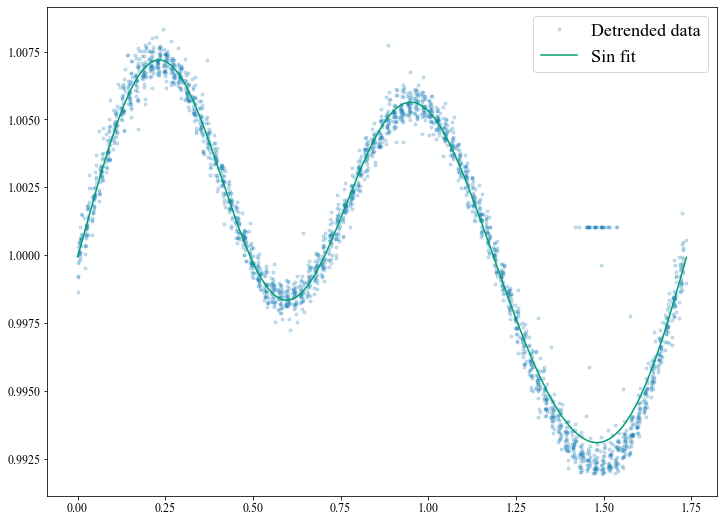

In [38]:
period_left_halo = 0.8681455964176481
y_fit_halo_left = ls_halo_left.model(xdata_left_halo,1/(2*period_left_halo))
# y_fit_right, delta_right, ff_right, pp_right = iterative_sine_fit(xdata_right, ydata_right, 2)

phase = (xdata_left_halo) % (period_left_halo*2)
args = np.argsort(phase)
fig = plt.figure(figsize=(12.0,9.0))

plt.plot(phase, ydata_left_halo,'.',alpha=0.2, label="Detrended data" )
plt.plot(phase[args], y_fit_halo_left[args],'-', label="Sin fit")
plt.legend(loc="upper right")

In [39]:
dm_halo_left = ls_halo_left.design_matrix(1/(period_left_halo)) # use the true period here

basis_v_halo_left = np.vander(normalize(xdata_left_halo),3)[:,:-1] # vander (short for vandermonde) is a matrix of 1, x, x**2 
# we want to throw away the constant term, which is listed last, because LS has one already
basis_halo_left = np.hstack([dm_halo_left,basis_v_halo_left]) # this makes a combined basis of constant, sines, x, and x**2

soln_4 = np.linalg.lstsq(basis_halo_left,ydata_left_halo) # this does the inverse square solution

coeffs_4 = soln_4[0] # lstsq returns the solution, and metadata about the solver



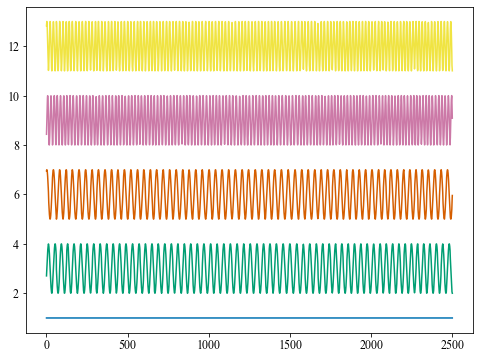

In [40]:
for j in range(5):
    plt.plot(dm_halo_left[:,j]+j*3)

In [41]:
constant_halo_left = coeffs_4[0]
fundamental_halo_left = np.sqrt(coeffs_4[1]**2 + coeffs_4[2]**2)
harmonic_halo_left = np.sqrt(coeffs_4[3]**2 + coeffs_4[4]**2)
print('Constant:',constant_halo_left)
print('Fundamental: %.2g' % fundamental_halo_left)
print('Harmonic: %.9g' % harmonic_halo_left)

Constant: 1.0009308038469842
Fundamental: 0.0049
Harmonic: 0.000127785276


In [42]:
residuals_left_halo = ydata_left_halo - y_fit_halo_left

In [43]:
freqs_noise_left_halo = np.linspace((1/10.),20.,1000000) # tess from 10 day period to 360 c/d nyquist
ls_noise_left_halo = LombScargle(xdata_left_halo, residuals_left_halo, normalization='psd', fit_mean=False, center_data=True)
power_noise_left_halo = ls_noise_left_halo.power(freqs_noise_left_halo)

Text(0.5, 1.0, 'Halo before eclipse')

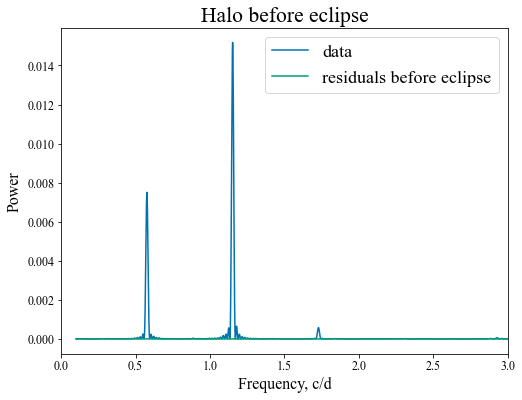

In [44]:
plt.plot(freqs_halo, power_halo_left, label="data")
plt.plot(freqs_noise_left_halo, power_noise_left_halo, label="residuals before eclipse")
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")
plt.title('Halo before eclipse')

Text(0.5, 1.0, 'Halo before eclipse')

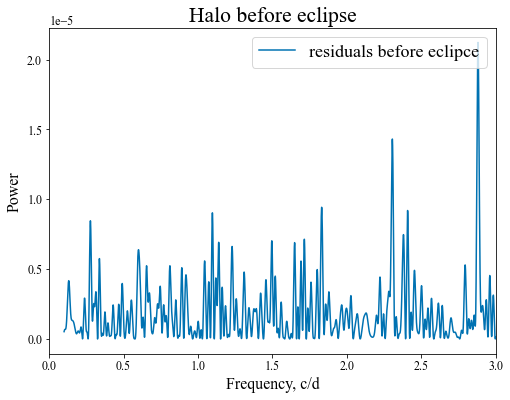

In [45]:
plt.plot(freqs_noise_left_halo, power_noise_left_halo, label="residuals before eclipce")
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")
plt.title('Halo before eclipse')

Before and after for K2:

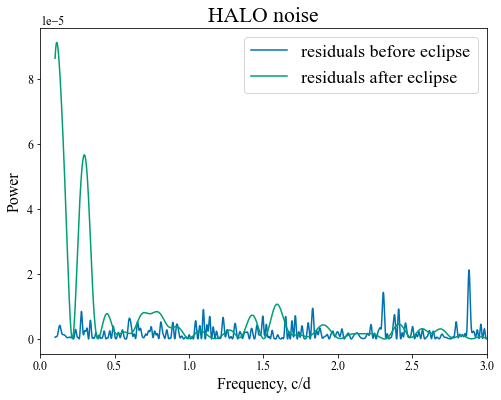

In [46]:
plt.plot(freqs_noise_left_halo, power_noise_left_halo, label="residuals before eclipse")
plt.plot(freqs_noise_right_halo, power_noise_right_halo, label="residuals after eclipse")
plt.title('HALO noise')
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")

# And now all together:

(1.0, 3.0)

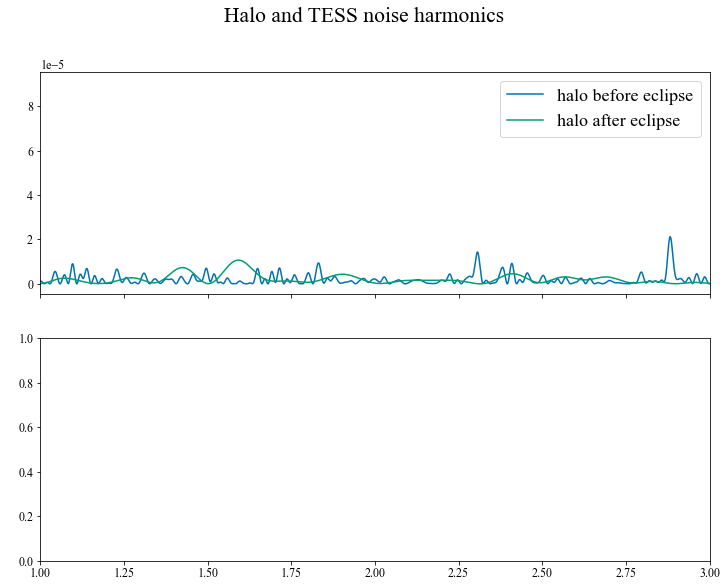

In [47]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12.0,9.0))
fig.suptitle('Halo and TESS noise harmonics')

ax1.plot(freqs_noise_left_halo, power_noise_left_halo, label="halo before eclipse")
ax1.plot(freqs_noise_right_halo, power_noise_right_halo, label="halo after eclipse")
ax1.legend(loc="upper right")

#ax2.plot(freqs_noise_left, power_noise_left, label="TESS before eclipse")
#ax2.plot(freqs_noise_right, power_noise_right, label="TESS after eclipse")
#ax2.legend(loc="upper right")

plt.xlim(1, 3.)

In [65]:
#trend_l = np.dot(basis_left[:,0],coeffs_left[0])
#trend_r = np.dot(basis_right[:,0],coeffs_right[0])
#
#fig = plt.figure()
#plt.plot(trend_l, label="tess before eclipse")
#plt.plot(trend_r, label="tess after eclipse")
#plt.legend(loc="upper right")
#
#trend_l = np.dot(basis_left[:,1:3],coeffs_left[1:3])
#trend_r = np.dot(basis_right[:,1:3],coeffs_right[1:3])
#
#fig = plt.figure()
#plt.plot(trend_l, label="tess before eclipse")
#plt.plot(trend_r, label="tess after eclipse")
#plt.legend(loc="upper right")
#
#trend_l = np.dot(basis_left[:,3:5],coeffs_left[3:5])
#trend_r = np.dot(basis_right[:,3:5],coeffs_right[3:5])
#
#fig = plt.figure()
#plt.plot(trend_l, label="tess before eclipse")
#plt.plot(trend_r, label="tess after eclipse")
#plt.legend(loc="upper right")
#
#
#trend_l = np.dot(basis_left[:,5:7],coeffs_left[5:7])
#trend_r = np.dot(basis_right[:,5:7],coeffs_right[5:7])
#
#fig = plt.figure()
#plt.plot(trend_l, label="tess before eclipse")
#plt.plot(trend_r, label="tess after eclipse")
#plt.legend(loc="upper right")

In [64]:
#trend_l = np.dot(basis_halo_left[:,0],coeffs_4[0])
#trend_r = np.dot(basis_halo_right[:,0],coeffs_3[0])
#
#fig = plt.figure()
#plt.plot(trend_l, label="halo before eclipse")
#plt.plot(trend_r, label="halo after eclipse")
#plt.legend(loc="upper right")
#
#trend_l = np.dot(basis_halo_left[:,1:3],coeffs_4[1:3])
#trend_r = np.dot(basis_halo_right[:,1:3],coeffs_3[1:3])
#
#fig = plt.figure()
#plt.xlim(0, 350)
#plt.plot(trend_l, label="halo before eclipse")
#plt.plot(trend_r, label="halo after eclipse")
#plt.legend(loc="upper right")
#
#trend_l = np.dot(basis_halo_left[:,3:5],coeffs_4[3:5])
#trend_r = np.dot(basis_halo_right[:,3:5],coeffs_3[3:5])
#
#fig = plt.figure()
#plt.xlim(0, 350)
#plt.plot(trend_l, label="halo before eclipse")
#plt.plot(trend_r, label="halo after eclipse")
#plt.legend(loc="upper right")
#
#
#trend_l = np.dot(basis_halo_left[:,5:7],coeffs_4[5:7])
#trend_r = np.dot(basis_halo_right[:,5:7],coeffs_3[5:7])
#
#fig = plt.figure()
#plt.plot(trend_l, label="halo before eclipse")
#plt.plot(trend_r, label="halo after eclipse")
#plt.legend(loc="upper right")

In [62]:
#CHECK BASIS COMPONENTS

#for j in range(7):
#   fig = plt.figure()
#   trend_l = np.dot(basis_left[:,j],coeffs_left[j])
#   trend_r = np.dot(basis_right[:,j],coeffs_right[j])
#   #plt.plot(trend_l+j*2)
#   plt.plot(trend_l, label = 'BEFORE')
#   plt.plot(trend_r, label = 'AFTER')
#   plt.legend(loc="upper right")
#   pltsave = PdfPages('tess_before_after.pdf')

In [59]:
#for j in range(9):
#    fig = plt.figure()
#   trend_l = np.dot(basis_left_halo[:,j],coeffs_left_halo[j])
#   trend_r = np.dot(basis_right_halo[:,j],coeffs_right[j])
#   #plt.plot(trend_l+j*2)
#   plt.plot(trend_l, label = 'BEFORE')
#   plt.plot(trend_r, label = 'AFTER')
#   plt.legend(loc="upper right")
#   pltsave = PdfPages('halo_before_after.pdf')

In [63]:
#plt.plot([0,1,2], [1, np.sqrt(coeffs_right_halo[1]**2 + coeffs_right_halo[2]**2), np.sqrt(coeffs_right_halo[3]**2 + coeffs_right_halo[4]**2)], '*')

In [60]:
x = [0,1,2]

dots_left_halo = [np.sqrt(coeffs_left_halo[1]**2 + coeffs_left_halo[2]**2), np.sqrt(coeffs_left_halo[3]**2 + coeffs_left_halo[4]**2), np.sqrt(coeffs_left_halo[5]**2 + coeffs_left_halo[6]**2)]
dots_right_halo = [np.sqrt(coeffs_right_halo[1]**2 + coeffs_right_halo[2]**2), np.sqrt(coeffs_right_halo[3]**2 + coeffs_right_halo[4]**2), np.sqrt(coeffs_right_halo[5]**2 + coeffs_right_halo[6]**2)]
dots_left = [np.sqrt(coeffs_left[1]**2 + coeffs_left[2]**2), np.sqrt(coeffs_left[3]**2 + coeffs_left[4]**2), np.sqrt(coeffs_left[5]**2 + coeffs_left[6]**2)]
dots_right = [np.sqrt(coeffs_right[1]**2 + coeffs_right[2]**2), np.sqrt(coeffs_right[3]**2 + coeffs_right[4]**2), np.sqrt(coeffs_right[5]**2 + coeffs_right[6]**2)]

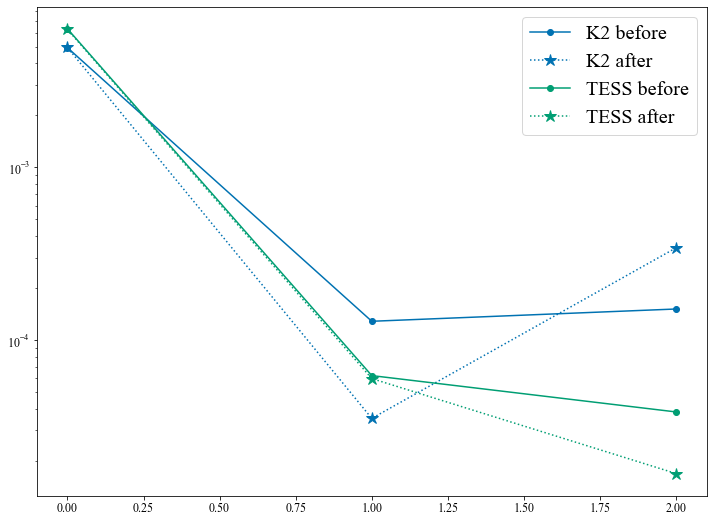

In [61]:
fig = plt.figure(figsize=(12.0,9.0))
#x = np.array(x)+1


# plt.stem(x, dots_left_halo, label = 'halo before', basefmt=" ", linefmt='grey', markerfmt ='C0-')
# (markerline, stemlines, baseline) = plt.stem(x, dots_left_halo)
#plt.setp(markerline, 'linestyle', '-')
#plt.setp(markerline, 'markerfacecolor', '#ffb7b2')
#plt.setp(markerline, 'markersize', '12')
#plt.setp(markerline, 'markeredgecolor', '#ff9aa2')
#plt.setp(markerline, 'color', '#ffb7b2')
#plt.setp(markerline, 'marker', "$\u266B$")


# plt.stem(x, dots_right_halo, label = 'halo after', basefmt=" ", linefmt='grey',markerfmt ='C0:')
# plt.stem(x, dots_left, label = 'tess before', basefmt=" ", linefmt='grey', markerfmt ='C1-')
# plt.stem(x, dots_right, label = 'tess after', basefmt=" ", linefmt='grey', markerfmt ='C1:')
# plt.plot(x, dots_right_halo, label = 'halo after', basefmt=" ", linefmt='grey',markerfmt ='C0:')

plt.plot(x, dots_left_halo,  'C0-', label = 'K2 before',marker='.',markersize=12)
plt.plot(x, dots_right_halo, 'C0:', label = 'K2 after',marker='*',markersize=12)


plt.plot(x, dots_left,  'C1-', label = 'TESS before',marker='.',markersize=12)
plt.plot(x, dots_right, 'C1:', label = 'TESS after',marker='*',markersize=12)


plt.legend(loc = 'upper right')
plt.yscale('log')
plt.legend(fontsize=20)
